In [1]:
import time
import numpy as np
import matplotlib.pylab as plt 
import emcee
from getdist import plots, MCSamples
import getdist
import scipy.stats as ss 
import pandas as pd

import numpyro 
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_value
from numpyro.handlers import seed
from numpyro.distributions import constraints
from numpyro.diagnostics import summary
from jax import grad, jit, vmap, jacfwd, jacrev
from utils.helpers import dill_save

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
ndim = 10
nchain = 2
tree_depth = 8
stepsize = 0.01
nsamples_nuts = 15000
nwarmup = 500

thin = 10
discard = 100
nsamples_emcee = int((nsamples_nuts * thin) / (2 * ndim) + discard)
fiducial = np.ones(ndim)
normal_prior = ss.norm(0, 1)

delta = 2.0
uniform_prior = ss.uniform(-delta, 2*delta)

In [3]:
def rosenbrock(xvalues):
    x_i_plus_one = xvalues[1::2]
    x_i = xvalues[0::2]
    term_1 = 0.001 * (x_i_plus_one - x_i**2)**2
    term_2 = (x_i - 1)**2
    return sum(term_1 + term_2)
    
def loglikelihood(xvalues):
    return -rosenbrock(xvalues)

@jax.jit
def jit_loglike(xvalues):
    return loglikelihood(xvalues)

@jax.jit
def jit_grad_loglike(xvalues):
    return jax.jacfwd(loglikelihood)(xvalues)
    
def logposterior(xvalues):
    # logprior = sum([uniform_prior.logpdf(xvalues[i]) for i in range(ndim)])
    logprior = sum([normal_prior.logpdf(xvalues[i]) for i in range(len(xvalues))])
    if np.isfinite(logprior):
        return logprior + jit_loglike(xvalues)
    return -1E32

def calculate_summary(samples_1, samples_2, nlike, ndecimal = 3):
    record = []
    for i in range(samples_1.shape[1]):
        testsamples = np.vstack(([samples_1[:,i], samples_2[:,i]]))
        summary_stats = summary(testsamples)
        summary_stats[f'p_{i}'] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(ndecimal).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['n_eff'] /= nlike
    return record_df

# $\frac{\tau[\nabla \mathcal{L}]}{\tau[\mathcal{L}]}$

In [4]:
%%timeit 
jit_loglike(fiducial)

84.1 µs ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
jit_loglike(fiducial)

35.6 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%%timeit
jit_grad_loglike(fiducial)

35 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
jit_grad_loglike(fiducial)

33.3 µs ± 642 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
dimensions = np.arange(1, 11, 1, dtype = int) * 40
nrepeat = 10

tau_like = []
tau_gradlike = []

for repeat in range(nrepeat):
    record_tau_like = []
    record_tau_grad_like = []
    
    for d in dimensions:
        testpoint = jnp.ones(d) + 1E-2
        
        start_time = time.time()
        loglike = jit_loglike(testpoint)
        time_taken = time.time() - start_time 
        record_tau_like.append(time_taken)
        
        start_time = time.time()
        grad_loglike = jit_grad_loglike(testpoint)
        time_taken = time.time() - start_time 
        record_tau_grad_like.append(time_taken)
    
    record_tau_like = np.asarray(record_tau_like)
    record_tau_grad_like = np.asarray(record_tau_grad_like)
    tau_like.append(record_tau_like)
    tau_gradlike.append(record_tau_grad_like)

tau_like = np.asarray(tau_like)
tau_gradlike = np.asarray(tau_gradlike)

In [9]:
time_ratio = np.mean(tau_gradlike / tau_like, axis = 0)
time_ratio_error = np.std(tau_gradlike / tau_like, axis = 0)

In [10]:
dill_save(time_ratio, 'rosenbrock', 'gL_L_time_ratio')
dill_save(time_ratio_error, 'rosenbrock', 'gL_L_time_ratio_error')

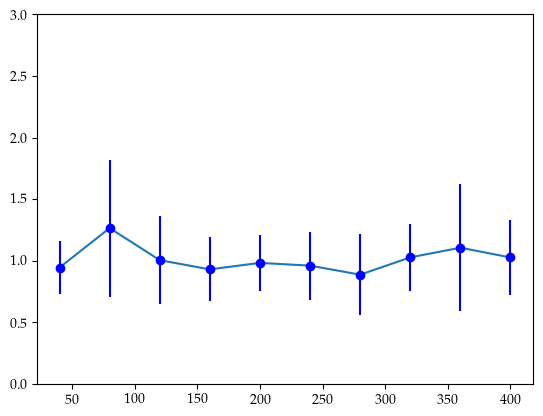

In [11]:
plt.plot(dimensions, time_ratio)
plt.errorbar(dimensions, time_ratio, yerr = time_ratio_error,fmt = 'bo')
plt.ylim(0, 3)
plt.show()

## EMCEE

In [12]:
def single_emcee_run(fiducial, thin = thin, ndim = ndim):
    pos = fiducial + 1e-3 * np.random.randn(2*ndim, ndim)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
    sampler.run_mcmc(pos, nsamples_emcee, progress=True)
    return sampler

def run_emcee(fiducial, discard = discard, thin = thin, ndim = ndim, nchain = 2):
    if nchain > 1:
        record_samples = []
        total_samples = 0
        for chain in range(nchain):
            sampler = single_emcee_run(fiducial, thin, ndim)
            emcee_samples = sampler.get_chain(discard = discard, thin = thin, flat = True)
            # emcee_samples = sampler.flatchain[::thin] 
            record_samples.append(emcee_samples)
            total_samples += sampler.flatchain.shape[0]
        return record_samples, total_samples
    
    sampler = single_emcee_run(fiducial, discard, thin, ndim)
    total_samples = sampler.flatchain.shape[0]
    emcee_samples = sampler.get_chain(discard = discard, thin = thin, flat = True)
    # emcee_samples = sampler.flatchain[::thin]
    return emcee_samples, total_samples

In [13]:
emcee_samples, nlike_emcee = run_emcee(fiducial, discard, thin, ndim, nchain = nchain)

100%|███████████████████████████████████████████████████████████████████████████████████████| 7600/7600 [02:23<00:00, 53.12it/s]


In [14]:
calculate_summary(emcee_samples[0], emcee_samples[1], nlike_emcee)

,r_hat,n_eff,mean,std
p_0,1.000,0.098821,0.675,0.577
p_1,1.001,0.047494,0.018,1.012
p_2,1.001,0.093881,0.671,0.587
p_3,1.002,0.087702,-0.007,1.000
p_4,1.001,0.103740,0.669,0.576
p_5,1.001,0.089702,0.007,1.013
p_6,1.000,0.100772,0.676,0.566
p_7,1.002,0.097023,0.025,0.992
p_8,1.000,0.099692,0.675,0.582
p_9,1.001,0.096337,-0.002,0.986


## NUTS

In [15]:
def model(ndim):
    xvalues = jnp.zeros(ndim)
    for i in range(ndim):
        # y = numpyro.sample(f"x{i}", dist.Uniform(-delta, delta))
        y = numpyro.sample(f"x{i}", dist.Normal(0, 1))
        xvalues = xvalues.at[i].set(y)
    numpyro.factor("log_prob", jit_loglike(xvalues))

In [16]:
%%capture
def run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, ndim = ndim, nchain = 2):
    init_strategy = init_to_value(
                values={f"x{i}": 1.0 for i in range(ndim)}
            )
    nuts_kernel = NUTS(model, step_size=stepsize, dense_mass=True, max_tree_depth=tree_depth, init_strategy=init_strategy)
    mcmc = MCMC(nuts_kernel, num_chains=nchain, num_warmup = nwarmup, num_samples=nsamples_nuts, chain_method='vectorized') 
    mcmc.run(jax.random.PRNGKey(0), ndim=ndim, extra_fields=('potential_energy', 'num_steps', 'accept_prob'))
    nlike_nuts = mcmc.get_extra_fields()['num_steps'].sum().item()
    return mcmc, nlike_nuts

In [17]:
def process_nuts_chains(mcmc, ndim = ndim):
    chains = mcmc.get_samples(group_by_chain = True)
    record = []
    for c in range(nchain):
        samples = np.vstack([np.asarray(chains[f'x{i}'][c]) for i in range(ndim)]).T
        record.append(samples)
    return record

In [18]:
mcmc, nlike_nuts = run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, ndim)

sample: 100%|████████████████████████████████████████████████████████████████████████████| 15500/15500 [00:57<00:00, 268.99it/s]


In [19]:
nuts_grouped = process_nuts_chains(mcmc, ndim)
nuts_samples = np.vstack([mcmc.get_samples()[f'x{i}'] for i in range(ndim)]).T

In [20]:
calculate_summary(nuts_grouped[0], nuts_grouped[1], nlike_nuts)

,r_hat,n_eff,mean,std
p_0,1.0,0.272551,0.662,0.575
p_1,1.0,0.269659,-0.003,0.995
p_2,1.0,0.284191,0.668,0.578
p_3,1.0,0.268022,0.007,0.999
p_4,1.0,0.271834,0.667,0.577
p_5,1.0,0.273011,-0.001,1.000
p_6,1.0,0.273318,0.664,0.582
p_7,1.0,0.295214,0.003,1.013
p_8,1.0,0.267782,0.665,0.577
p_9,1.0,0.255949,0.001,0.998


## Plots

In [21]:
emcee_samples_flat = np.concatenate(emcee_samples)

In [22]:
ndimplot = ndim # 10
names = ["x%s"%i for i in range(ndimplot)]
labels =  [f"$x_{i}$" for i in range(ndimplot)]
samples_emcee = MCSamples(samples=emcee_samples_flat[:,0:ndimplot],names = names, labels = labels)
samples_nuts = MCSamples(samples=nuts_samples[:,0:ndimplot],names = names, labels = labels)

Removed no burn in
Removed no burn in


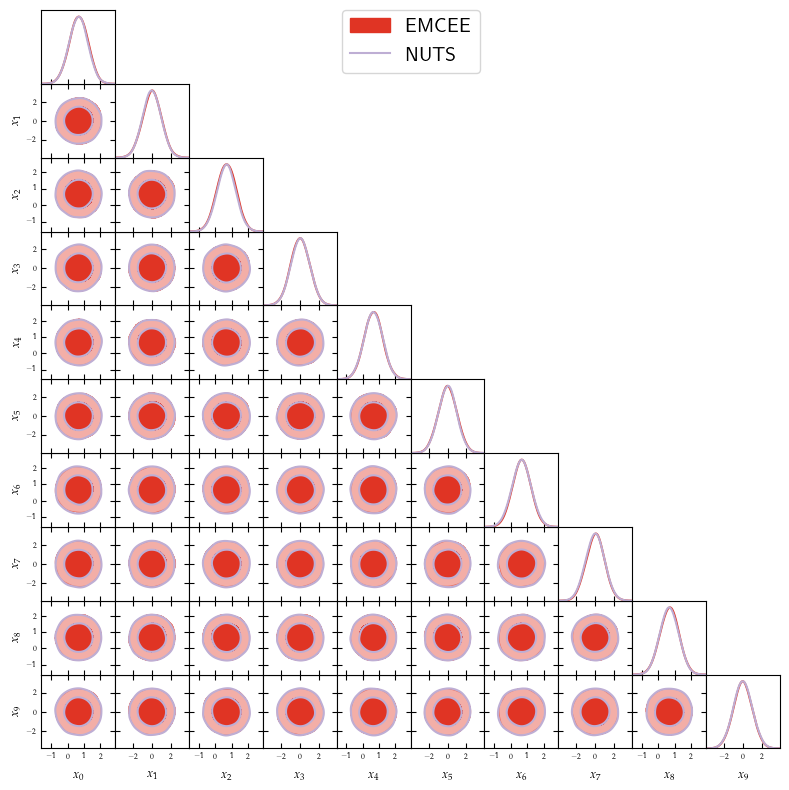

In [23]:
g = plots.get_subplot_plotter(width_inch=8)
g.settings.line_styles = 'Accent'
g.settings.legend_fontsize = 20
g.triangle_plot([samples_emcee, samples_nuts], filled=[True, False], contour_lws=1.5, legend_labels=['EMCEE', 'NUTS'])
plt.show()

# Many Dimensions

In [24]:
# testdim = np.arange(1, 6, 1) * 2
testdim = np.arange(1, 11, 1) * 20

In [ ]:
stats_emcee = {}
nlike_emcee_record = {}
time_emcee = {}

for d in testdim:
    initial = np.ones(d)
    
    start_time = time.time()
    emcee_samples, nlike_emcee = run_emcee(initial, discard, thin, d, nchain = nchain)
    time_emcee[d] = time.time() - start_time 

    stats_emcee[d] = calculate_summary(emcee_samples[0], emcee_samples[1], nlike_emcee)
    nlike_emcee_record[d] = nlike_emcee

 19%|████████████████                                                                   | 1476/7600 [1:49:06<7:35:23,  4.46s/it]

In [ ]:
stats_nuts = {}
nlike_nuts_record = {}
time_nuts = {}

for d in testdim:
    start_time = time.time()
    mcmc, nlike_nuts = run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, d)
    time_nuts[d] = time.time() - start_time 
    
    nuts_grouped = process_nuts_chains(mcmc, d)
    stats_nuts[d] = calculate_summary(nuts_grouped[0], nuts_grouped[1], nlike_nuts)
    nlike_nuts_record[d] = nlike_nuts

In [ ]:
nlike_nuts_record

In [ ]:
nlike_emcee_record

In [ ]:
time_nuts

In [ ]:
time_emcee

In [ ]:
mean_neff_emcee = np.asarray([stats_emcee[d]['n_eff'].mean() for d in testdim]) / np.asarray(list(time_emcee.values()))
mean_neff_nuts = np.asarray([stats_nuts[d]['n_eff'].mean() for d in testdim]) / np.asarray(list(time_nuts.values()))

In [ ]:
ratio_neff = mean_neff_nuts / mean_neff_emcee

In [ ]:
ratio_neff

In [ ]:
dill_save(stats_nuts, 'rosenbrock', 'stats_nuts')
dill_save(nlike_nuts_record, 'rosenbrock', 'nlike_nuts')
dill_save(time_nuts, 'rosenbrock', 'time_nuts')

In [ ]:
dill_save(stats_emcee, 'rosenbrock', 'stats_emcee')
dill_save(nlike_emcee_record, 'rosenbrock', 'nlike_emcee')
dill_save(time_emcee, 'rosenbrock', 'time_emcee')